Epoch 0, Loss: 1.555829405784607
Epoch 1000, Loss: 0.03566307947039604
Epoch 2000, Loss: 0.02935214899480343
Epoch 3000, Loss: 0.02829083800315857
Epoch 4000, Loss: 0.028292810544371605
Epoch 5000, Loss: 0.027903329581022263
Epoch 6000, Loss: 0.027663428336381912
Epoch 7000, Loss: 0.027376148849725723
Epoch 8000, Loss: 0.026961809024214745
Epoch 9000, Loss: 0.026714399456977844
Model saved to pinn_model.pth


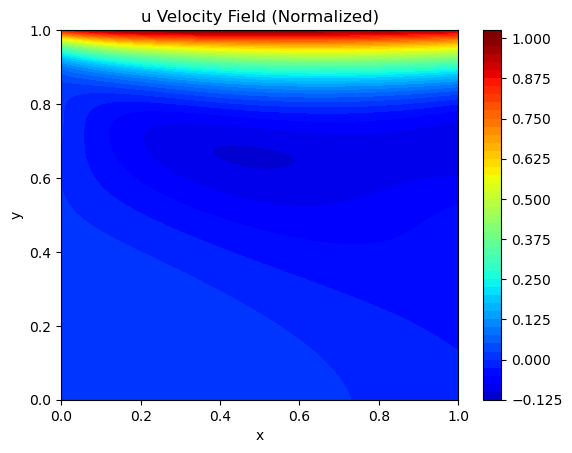

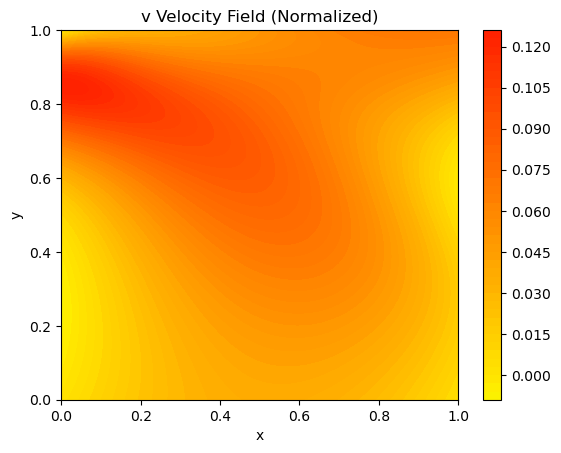

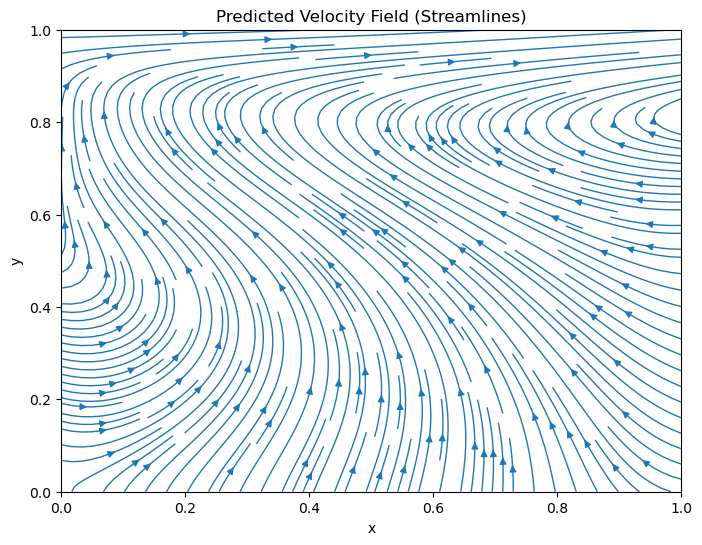

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Reference scales for normalization
L_r = 1.0  #length scale
U_r = 1.0  #velocity scale
rho_r = 1.0  #density
nu_r = 1.0  #kinematic viscosity

# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(2, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 2)  # Outputs u and v velocities

    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        return self.output(x)

# Loss functions
def boundary_loss(model, x_boundary):
    uv_pred = model(x_boundary)
    u_pred, v_pred = uv_pred[:, 0:1], uv_pred[:, 1:2]
    
    # Normalize the predicted velocities
    u_pred = u_pred * U_r
    v_pred = v_pred * U_r
    
    # Top boundary (moving lid)
    top_mask = (x_boundary[:, 1] == 1)
    top_loss = torch.mean((u_pred[top_mask] - U_r)**2 + v_pred[top_mask]**2)
    
    # Other boundaries (no-slip)
    other_mask = ~top_mask
    other_loss = torch.mean(u_pred[other_mask]**2 + v_pred[other_mask]**2)
    
    return top_loss + other_loss

def navier_stokes_residual(model, x, Re=100):
    x.requires_grad_(True)
    uv = model(x)
    u, v = uv[:, 0:1], uv[:, 1:2]

    # Normalize velocities
    u = u * U_r
    v = v * U_r

    du_dx = torch.autograd.grad(u.sum(), x, create_graph=True)[0][:, 0:1]
    du_dy = torch.autograd.grad(u.sum(), x, create_graph=True)[0][:, 1:2]
    dv_dx = torch.autograd.grad(v.sum(), x, create_graph=True)[0][:, 0:1]
    dv_dy = torch.autograd.grad(v.sum(), x, create_graph=True)[0][:, 1:2]
    
    d2u_dx2 = torch.autograd.grad(du_dx.sum(), x, create_graph=True)[0][:, 0:1]
    d2u_dy2 = torch.autograd.grad(du_dy.sum(), x, create_graph=True)[0][:, 1:2]
    d2v_dx2 = torch.autograd.grad(dv_dx.sum(), x, create_graph=True)[0][:, 0:1]
    d2v_dy2 = torch.autograd.grad(dv_dy.sum(), x, create_graph=True)[0][:, 1:2]
    
    continuity = du_dx + dv_dy
    momentum_x = u * du_dx + v * du_dy - (1/Re) * (d2u_dx2 + d2u_dy2)
    momentum_y = u * dv_dx + v * dv_dy - (1/Re) * (d2v_dx2 + d2v_dy2)
    
    return torch.mean(continuity**2 + momentum_x**2 + momentum_y**2)

# Training the model
def train_pinn(model, epochs=5000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Generate collocation points
    x_collocation = torch.rand(10000, 2)  # Random points in the domain
    x_collocation = x_collocation.requires_grad_(True)  # Require gradients
    
    # Generate boundary points
    top_boundary = torch.cat([torch.linspace(0, 1, 100).view(-1, 1), torch.ones(100).view(-1, 1)], dim=1)  # Top
    bottom_boundary = torch.cat([torch.linspace(0, 1, 100).view(-1, 1), torch.zeros(100).view(-1, 1)], dim=1)  # Bottom
    left_boundary = torch.cat([torch.zeros(100).view(-1, 1), torch.linspace(0, 1, 100).view(-1, 1)], dim=1)  # Left
    right_boundary = torch.cat([torch.ones(100).view(-1, 1), torch.linspace(0, 1, 100).view(-1, 1)], dim=1)  # Right

    # Combine all boundary points and normalize
    x_boundary = torch.cat([top_boundary, bottom_boundary, left_boundary, right_boundary])
    x_boundary = x_boundary / L_r  # Normalize by reference length scale

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Compute the loss
        boundary_loss_value = boundary_loss(model, x_boundary)
        navier_stokes_loss_value = navier_stokes_residual(model, x_collocation)
        
        loss = boundary_loss_value + navier_stokes_loss_value
        loss.backward()
        optimizer.step()
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Save the model after training
    torch.save(model.state_dict(), 'pinn_model.pth')
    print("Model saved to pinn_model.pth")

# Plotting results
def plot_velocity_fields(model):
    x_test = np.linspace(0, 1, 100)
    y_test = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x_test, y_test)
    X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1) / L_r  # Normalize
    Y_tensor = torch.tensor(Y.flatten(), dtype=torch.float32).view(-1, 1) / L_r  # Normalize

    with torch.no_grad():
        uv = model(torch.cat([X_tensor, Y_tensor], dim=1)).numpy()

    U = uv[:, 0].reshape(X.shape) * U_r  
    V = uv[:, 1].reshape(Y.shape) * U_r 

    # Plotting u velocity field
    plt.contourf(X, Y, U, levels=50, cmap='jet', vmin=-0.2, vmax=1)
    plt.colorbar()
    plt.title("u Velocity Field (Normalized)")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    # Plotting v velocity field
    plt.contourf(X, Y, V, levels=50, cmap='jet', vmin=-0.4, vmax=0.2)
    plt.colorbar()
    plt.title("v Velocity Field (Normalized)")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    # Plot streamlines
    plt.figure(figsize=(8, 6))
    plt.streamplot(
        X, Y, U, V, density=2, linewidth=1, arrowsize=1
    )
    plt.title('Predicted Velocity Field (Streamlines)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

# Main execution
if __name__ == "__main__":
    model = PINN()
    train_pinn(model, epochs=10000, lr=0.001)
    plot_velocity_fields(model)
